In [1]:
# %matplotlib notebook
import numpy as np
import numpy.random
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Set-up.
n = 10000

num_bins = 100

# Parameters of the mixture components
# E.g. first Normal, mean = 6 and sd = 2.
norm_params = np.array([[6, 2],
                        [-3, 4],
                        [15, 3]])

# Weight of each component
weights = np.array([1, 2, 3])
weights = weights/np.sum(weights)

# Number of components.
assert len(weights) == norm_params.shape[0]
n_components = norm_params.shape[0]

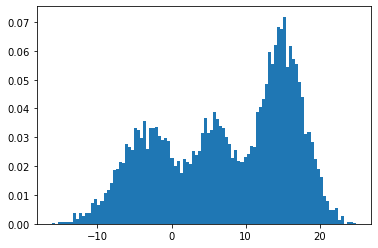

In [3]:
"""
Approach 1
"""
# Step1, assign each point to a certrain Gaussian distribution
# A stream of indices from which to choose the component
mixture_idx = numpy.random.choice(n_components, size=n, replace=True, p=weights)

# Step 2: draw r.v. from signle normal distributions.
# y is the mixture sample
y_1 = numpy.fromiter((norm.rvs(*(norm_params[i])) for i in mixture_idx), dtype=np.float64)

fig, ax = plt.subplots()

# the histogram of the data
_ = ax.hist(y_1, num_bins, density=1)

(3, 10000)


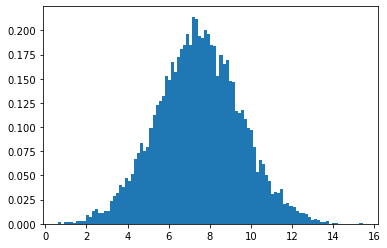

In [4]:
"""
Approach 2
"""

# Step1, generate N random variables from each single Normal distribution
Random_Variables = np.array([norm.rvs(loc = norm_params[i][0], scale = norm_params[i][1], size=n) for i in range(n_components)])
print(Random_Variables.shape)


# Step 2: Treate it as a weighted sum
y_2 = weights @ Random_Variables


fig, ax = plt.subplots()

# the histogram of the data
_ = ax.hist(y_2, num_bins, density=1)

## EM Algorithm

In [5]:
def E_step(observation, loc, scale, pi):
    # Smoothing term
    st = 1e-40
    number_of_obervations = len(observation)
    number_of_components = len(loc)
    # Init responsibility matrix
    responsibilities = np.empty([number_of_obervations, number_of_components])
    # Compute Gaussian pdf
    for i in range(number_of_components):
        responsibilities[:,i] = norm.pdf(observation, loc[i], scale[i]) + st
    # Compute the numberator pi * pdf, element-wise product
    responsibilities = responsibilities * pi
    # Normalised by the sum of each row.
    responsibilities = (responsibilities.T / np.sum(responsibilities, axis=1)).T

    return responsibilities


In [6]:
def M_step(observation, responsibilities):
    number_of_obervations, number_of_components = responsibilities.shape
    # 1. Calculate the location vector
    loc_star = np.sum((responsibilities.T * observation), axis=1) / np.sum(responsibilities, axis=0)

    # 2-1. Calculate (y-mu)^2
    difference_square = (np.repeat(observation.reshape(-1,1), number_of_components, axis=1) - loc_star) ** 2
    # 2-2. Calculate the scale vector
    scale_star = np.sum((responsibilities * difference_square), axis=0) / np.sum((responsibilities), axis=0)
    scale_star = scale_star ** (1/2)# Sd rather than Var
    
    # 3. Calculate pi
    pi_star = np.mean(responsibilities, axis=0)

    return loc_star, scale_star, pi_star

In [7]:
# init Step
"""
Since we don't know the actual number of Gaussian components, this should be treated as a hyper-parameter.
"""
EM_n_components = 3 # Hyper parameter

# uniformaly init the parameters
# Locatgion parameters
EM_loc = np.random.rand(EM_n_components)*10
# Scale parameters (sd)
EM_scale = np.random.rand(EM_n_components)*10
# Weights
EM_pi = np.ones(EM_n_components)
EM_pi = EM_pi/np.sum(EM_pi)


In [8]:
for i in range(100):
    responsibilities = E_step(observation = y_1, loc = EM_loc, scale = EM_scale, pi = EM_pi)
    EM_loc, EM_scale, EM_pi = M_step(observation = y_1, responsibilities = responsibilities)
print("Location:", EM_loc)
print("Scale:", EM_scale)
print("Pi:", EM_pi)

Location: [15.49563768  6.1393063  -4.2182128 ]
Scale: [2.67602166 4.26307436 3.52026252]
Pi: [0.42082361 0.31919743 0.25997896]
